# Complexity measure as peaks

In [14]:
from disassembly.simulate_proteolysis import enzyme_set, enzyme, amino_acids


kr = enzyme_set(
    [
        enzyme({"K": 1}, "K protease"),
    ],
    [1],
    [1],
)


viat = enzyme_set(
    [
        enzyme({"V": 0.35, "I": 0.25, "A": 0.2, "T": 0.1}, "V+I+A+T protease"),
    ],
    [1],
    [1],
)

random = enzyme_set(
    [enzyme({aa: 1 / len(amino_acids) for aa in amino_acids.values()}, "random")],
    [1],
    [1],
)
protein = "MKAAVLTLAVLFLTGSQARHFWQQDEPPQSPWDRVKDLATVYVDVLKDSGRDYVSQFEGSALGKQLNLKLLDNWDSVTSTFSKLREQLGPVTQEFWDNLEKETEGLRQEMSKDLEEVKAKVQPYLDDFQKKWQEEMELYRQKVEPLRAELQEGARQKLHELQEKLSPLGEEMRDRARAHVDALRTHLAPYSDELRQRLAARLEALKENGGARLAEYHAKATEHLSTLSEKAKPALEDLRQGLLPVLESFKVSFLSALEEYTKKLNTQ"

In [15]:
from disassembly.benchmark import Benchmark

n_iterations = 5
bmrk = Benchmark()

enzyme_sets = [kr, viat, random]
enzyme_names = ["K", "V+I+A+T", "random"]

bmrk.simulate_degradation(
    protein,
    enzyme_sets=enzyme_sets,
    enzyme_names=enzyme_names,
    n_generate=100,
    endo_or_exo_probability=[0.9, 0.1],
    iterations=n_iterations,
)

Running K, 0
 0 / 100 (1)

 44 / 100 (53)

/Users/erikhartman/dev/disassembly/src/disassembly/simulate_proteolysis.py:227: RuntimeWarning: invalid value encountered in scalar divide
  p / sum(index_to_cut.values()) for p in index_to_cut.values()


 99 / 100 (122)
56 unique peptides. 103 total

 Averaged DI: 1.46
Running K, 1
 99 / 100 (107)
62 unique peptides. 104 total

 Averaged DI: 1.48
Running K, 2
 99 / 100 (113)
49 unique peptides. 103 total

 Averaged DI: 1.47
Running K, 3
 99 / 100 (115)
61 unique peptides. 103 total

 Averaged DI: 1.50
Running K, 4
 99 / 100 (126)
55 unique peptides. 103 total

 Averaged DI: 1.58
Running V+I+A+T, 0
 99 / 100 (113)
73 unique peptides. 103 total

 Averaged DI: 1.54
Running V+I+A+T, 1
 99 / 100 (113)
78 unique peptides. 103 total

 Averaged DI: 1.57
Running V+I+A+T, 2
 99 / 100 (113)
74 unique peptides. 103 total

 Averaged DI: 1.49
Running V+I+A+T, 3
 99 / 100 (113)
80 unique peptides. 103 total

 Averaged DI: 1.48
Running V+I+A+T, 4
 99 / 100 (111)
84 unique peptides. 103 total

 Averaged DI: 1.39
Running random, 0
 99 / 100 (109)
101 unique peptides. 103 total

 Averaged DI: 1.73
Running random, 1
 99 / 100 (105)
101 unique peptides. 103 total

 Averaged DI: 1.66
Running random, 2
 99 /

In [16]:
import numpy as np
from disassembly.util import KL

dct = {"e": [], "i": [], "error": [], "kl": [], "d": []}
for enzyme_name in bmrk.enzyme_names:

    for iteration in range(bmrk.iterations):

        spaces = np.zeros(len(protein))

        for sequence, copy_number in bmrk.simulated_peptidomes[enzyme_name][
            iteration
        ].items():
            start = protein.find(sequence)
            end = start + len(sequence)
            spaces[start:end] += copy_number

        mean = np.mean(spaces)
        error = np.sum(np.abs(spaces - mean) ** 2)
        kl = KL(np.ones(len(protein)) * mean, spaces)
        dct["e"].append(enzyme_name)
        dct["i"].append(iteration)
        dct["error"].append(error)
        dct["kl"].append(kl)
        dct["d"].append(bmrk.results["real"][enzyme_name][iteration]["d"])

<Axes: xlabel='kl', ylabel='Density'>

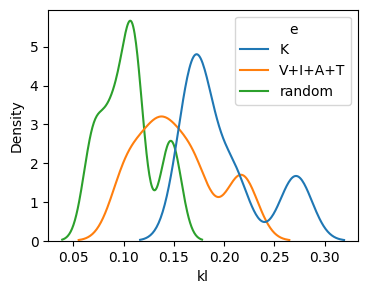

In [17]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

dct_df = pd.DataFrame(dct)
plt.figure(figsize=(4, 3))
sns.kdeplot(dct_df, x="kl", hue="e", bw_adjust=0.5)

<Axes: xlabel='d', ylabel='Density'>

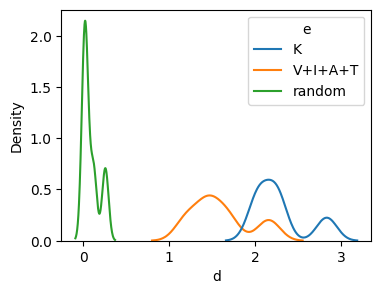

In [18]:
plt.figure(figsize=(4, 3))
sns.kdeplot(dct_df, x="d", hue="e", bw_adjust=0.5)

Text(0.5, 1.0, 'n_generate=1000')

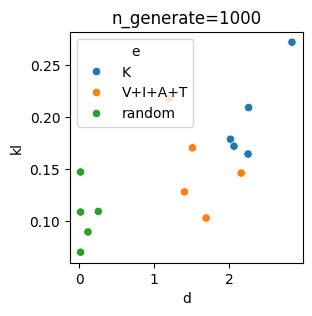

In [19]:
plt.figure(figsize=(3, 3))
sns.scatterplot(dct_df, x="d", y="kl", hue="e")
plt.title("n_generate=1000")

# Regex enzyme

In [5]:
import re
import numpy as np

class Enzyme:
    def __init__(self, name: str, cleavage_rules: dict):
        self.name = name
        self.cleavage_rules = cleavage_rules

    def cleave(self, protein_sequence):
        cleavage_probabilities = np.zeros(len(protein_sequence))
        for pattern, amount in self.cleavage_rules.items():
            regex_pattern = re.compile(pattern)
            matches = regex_pattern.finditer(protein_sequence)
            cleavage_indices = [match.start() + 3 for match in matches]
            for cleavage_index in cleavage_indices:
                cleavage_probabilities[cleavage_index] += amount
        cleavage_probabilities = cleavage_probabilities / sum(cleavage_probabilities)
        return cleavage_probabilities

# Create an instance of the Enzyme class for elastase with custom cleavage rates
elastase = Enzyme("trypsin", {"..[RK](?!P).." : 1})

# Test the cleavage_probabilities method
protein_sequence = "MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANTFLEEVRKGNLERECVEETCSYEEAFEALESSTATDVFWAKYTACETARTPRDKLAACLEGNCAEGLGTNYRGHVNITRSGIECQLWRSRYPHKPEINSTTHPGADLQENFCRNPDSSTTGPWCYTTDPTVRRQECSIPVCGQDQVTVAMTPRSEGSSVNLSPPLEQCVPDRGQQYQGRLAVTTHGLPCLAWASAQAKALSKHQDFNSAVQLVENFCRNPDGDEEGVWCYVAGKPGDFGYCDLNYCEEAVEEETGDGLDEDSDRAIEGRTATSEYQTFFNPRTFGSGEADCGLRPLFEKKSLEDKTERELLESYIDGRIVEGSDAEIGMSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLLYPPWDKNFTENDLLVRIGKHSRTRYERNIEKISMLEKIYIHPRYNWRENLDRDIALMKLKKPVAFSDYIHPVCLPDRETAASLLQAGYKGRVTGWGNLKETWTANVGKGQPSVLQVVNLPIVERPVCKDSTRIRITDNMFCAGYKPDEGKRGDACEGDSGGPFVMKSPFNNRWYQMGIVSWGEGCDRDGKYGFYTHVFRLKKWIQKVIDQFGE"

print("Cleavage probabilities for elastase:", elastase.cleave(protein_sequence))

Cleavage probabilities for elastase: [0.         0.         0.         0.         0.         0.02173913
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.02173913
 0.         0.         0.         0.         0.02173913 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.02173913 0.
 0.         0.         0.         0.         0.02173913 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.02173913 0.         0.         0.
 0.         0.         0.         0.         0.02173913 0.
 0.

In [6]:
from disassembly.simulate_proteolysis_regex import ProteolysisSimulator

ps = ProteolysisSimulator()

ps.simulate_proteolysis(protein_sequence, n_generate=10)

 0 / 10 (3)43 498
MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRR ANTFLEEVRKGNLERECVEETCSYEEAFEALESSTATDVFWAKYTACETARTPRDKLAACLEGNCAEGLGTNYRGHVNITRSGIECQLWRSRYPHKPEINSTTHPGADLQENFCRNPDSSTTGPWCYTTDPTVRRQECSIPVCGQDQVTVAMTPRSEGSSVNLSPPLEQCVPDRGQQYQGRLAVTTHGLPCLAWASAQAKALSKHQDFNSAVQLVENFCRNPDGDEEGVWCYVAGKPGDFGYCDLNYCEEAVEEETGDGLDEDSDRAIEGRTATSEYQTFFNPRTFGSGEADCGLRPLFEKKSLEDKTERELLESYIDGRIVEGSDAEIGMSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLLYPPWDKNFTENDLLVRIGKHSRTRYERNIEKISMLEKIYIHPRYNWRENLDRDIALMKLKKPVAFSDYIHPVCLPDRETAASLLQAGYK GRVTGWGNLKETWTANVGKGQPSVLQVVNLPIVERPVCKDSTRIRITDNMFCAGYKPDEGKRGDACEGDSGGPFVMKSPFNNRWYQMGIVSWGEGCDRDGKYGFYTHVFRLKKWIQKVIDQFGE
 1 / 10 (4)86 596
MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANTFLEEVRKGNLERECVEETCSYEEAFEALESSTATDVFWAK YTACETARTPRDKLAACLEGNCAEGLGTNYRGHVNITRSGIECQLWRSRYPHKPEINSTTHPGADLQENFCRNPDSSTTGPWCYTTDPTVRRQECSIPVCGQDQVTVAMTPRSEGSSVNLSPPLEQCVPDRGQQYQGRLAVTTHGLPCLAWASAQAKALSKHQDFNSAVQLVENFCRNPDGDEEGVWCYVAGKPGDFGYCDLNYCEEAVEEETGDGLDEDSDRAIEGRTATSEYQTFFNPRTFGSGEADCGL

({'MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANTFLEEVRKGNLERECVEETCSYEEAFEALESSTATDVFWAKYTACETARTPRDKLAACLEGNCAEGLGTNYRGHVNITRSGIECQLWRSRYPHKPEINSTTHPGADLQENFCRNPDSSTTGPWCYTTDPTVRRQECSIPVCGQDQVTVAMTPRSEGSSVNLSPPLEQCVPDRGQQYQGRLAVTTHGLPCLAWASAQAKALSKHQDFNSAVQLVENFCRNPDGDEEGVWCYVAGKPGDFGYCDLNYCEEAVEEETGDGLDEDSDRAIEGRTATSEYQTFFNPRTFGSGEADCGLRPLFEKKSLEDKTERELLESYIDGRIVEGSDAEIGMSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLLYPPWDKNFTENDLLVRIGKHSRTRYERNIEKISMLEKIYIHPRYNWRENLDRDIALMKLKKPVAFSDYIHPVCLPDRETAASLLQAGYKGRVTGWGNLKETWTANVGKGQPSVLQVVNLPIVERPVCKDSTRIRITDNMFCAGYKPDEGKRGDACEGDSGGPFVMKSPFNNRWYQMGIVSWGEGCDRDGKYGFYTHVFRLKKWIQKVIDQFGE': 10,
  'ANTFLEEVRKGNLERECVEETCSYEEAFEALESSTATDVFWAKYTACETARTPRDKLAACLEGNCAEGLGTNYRGHVNITRSGIECQLWRSRYPHKPEINSTTHPGADLQENFCRNPDSSTTGPWCYTTDPTVRRQECSIPVCGQDQVTVAMTPRSEGSSVNLSPPLEQCVPDRGQQYQGRLAVTTHGLPCLAWASAQAKALSKHQDFNSAVQLVENFCRNPDGDEEGVWCYVAGKPGDFGYCDLNYCEEAVEEETGDGLDEDSDRAIEGRTATSEYQTFFNPRTFGSGEADCGLRPLFEKKSLEDKTERELLESYIDGRIVEGSDAEIGMSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCL